In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from libs.utils_pollution import *
from libs.utils_meteorological import *
from libs.utils_data import *
from libs.utils_spatial import *

# Préparation des données

In [4]:
# Export all useful constants
borough_geojson_file = 'https://data.montreal.ca/dataset/b628f1da-9dc3-4bb1-9875-1470f891afb1/resource/92cb062a-11be-4222-9ea5-867e7e64c5ff/download/limites-terrestres.geojson'
borough_geojson_file = './data/limites-terrestres.geojson'
# csv_stations_references = 'https://data.montreal.ca/dataset/ae01f7f3-4d69-404a-9be1-74abfdc96571/resource/29db5545-89a4-4e4a-9e95-05aa6dc2fd80/download/liste-des-stations-rsqa.csv'
csv_stations_references = './data/liste-des-stations-rsqa.csv'
# csv_all_pollutants = 'https://data.montreal.ca/dataset/a2eea289-f9b1-4e51-a6fc-3299aa8f2ba7/resource/811e76d0-90cb-4703-bd6f-bd0faff81f4a/download/rsqa-multi-polluants2020.csv'
csv_all_pollutants = './data/rsqa-multi-polluants2020.csv'
meteorological_stations_ids = [51157, 49608, 30165, 48374]
csv_meteo_api = 'https://climat.meteo.gc.ca/climate_data/bulk_data_f.html?format=csv&stationID={STATIONID}&Year={YEAR}&Month={MONTH}&Day={DAY}&time=UTC&timeframe=1&submit=T%C3%A9l%C3%A9charger%20des%20donn%C3%A9es'

## Visualisation des stations de pollution

In [5]:
stations_references = pd.read_csv(csv_stations_references)

<Figure size 1440x1440 with 0 Axes>

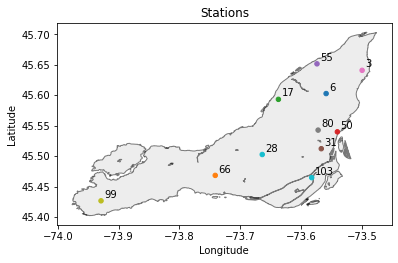

In [6]:
visualise_stations(stations_references[stations_references.statut == 'ouvert'], borough_geojson_file)

## Importation des données de pollution

In [7]:
pollution_data = pd.read_csv(csv_all_pollutants)
pollution_data.head()

,numero_station,date_heure,co,no,no2,pm2_5,pst,pm10,o3,so2,bc1_370nm,bc6_880nm,Benzene,Toluene,Ethylbenzene,M P-Xylene,O-Xylene
0,3,01-01-2020 01:00,N/M,0.121867,8.667018,8.746077,N/M,N/M,15.65643,0,N/M,N/M,5.743625,2.754026,0.355111,6.189929,0.569096
1,3,01-01-2020 02:00,N/M,0.070021,5.937763,5.5934,N/M,N/M,16.69138,0,N/M,N/M,1.40336,1.692388,0.479124,17.34458,0.638791
2,3,01-01-2020 03:00,N/M,0.847384,10.14027,6.916233,N/M,N/M,13.30661,0,N/M,N/M,1.384068,1.533221,0.363582,13.26551,0.476262
3,3,01-01-2020 04:00,N/M,0.343275,6.808739,6.848,N/M,N/M,15.83292,0,N/M,N/M,1.364819,1.456055,0.346235,11.88057,0.420513
4,3,01-01-2020 05:00,N/M,0.085947,4.765573,6.238298,N/M,N/M,17.40574,0,N/M,N/M,0.785679,1.041375,0.248069,9.535387,0.309693


In [8]:
pollution_data = transform_all_pollutants_data(pollution_data)
pollution_data = convert_unknown_values_to_na(pollution_data)
pollution_data = remove_empty_columns(pollution_data)

# keep only first month
pollution_data = pollution_data.iloc[:360]

pollution_data.head()

,no_station_3,no2_station_3,pm2_5_station_3,o3_station_3,so2_station_3,Benzene_station_3,Toluene_station_3,Ethylbenzene_station_3,M P-Xylene_station_3,O-Xylene_station_3,...,no2_station_99,pm2_5_station_99,o3_station_99,so2_station_99,no_station_103,no2_station_103,pm2_5_station_103,pst_station_103,pm10_station_103,o3_station_103
date_heure,,,,,,,,,,,,,,,,,,,,,
2020-01-01 01:00:00,0.121867,8.667018,8.746077,15.65643,0.0,5.743625,2.754026,0.355111,6.189929,0.569096,...,3.248914,2.837178,20.53666,0.0,0.000000,4.582468,4.249444,5.496387,5.493054,18.90542
2020-01-01 02:00:00,0.070021,5.937763,5.593400,16.69138,0.0,1.403360,1.692388,0.479124,17.344580,0.638791,...,3.324254,3.145111,20.52980,0.0,0.000000,4.323431,5.813416,8.411389,8.065554,18.67736
2020-01-01 03:00:00,0.847384,10.140270,6.916233,13.30661,0.0,1.384068,1.533221,0.363582,13.265510,0.476262,...,3.744425,3.346333,19.87264,0.0,0.076251,4.195025,5.367332,8.120139,7.684998,18.52408
2020-01-01 04:00:00,0.343275,6.808739,6.848000,15.83292,0.0,1.364819,1.456055,0.346235,11.880570,0.420513,...,3.026699,3.581054,21.03147,0.0,0.000000,4.036451,4.810264,6.188667,6.111941,18.76897
2020-01-01 05:00:00,0.085947,4.765573,6.238298,17.40574,0.0,0.785679,1.041375,0.248069,9.535387,0.309693,...,1.800147,3.109388,21.96484,0.0,0.000000,3.402587,4.696846,7.290452,6.689124,19.69922


In [9]:
pollution_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 2020-01-01 01:00:00 to 2020-01-16 00:00:00
Data columns (total 64 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   no_station_3            360 non-null    float64
 1   no2_station_3           360 non-null    float64
 2   pm2_5_station_3         360 non-null    float64
 3   o3_station_3            360 non-null    float64
 4   so2_station_3           360 non-null    float64
 5   Benzene_station_3       360 non-null    float64
 6   Toluene_station_3       360 non-null    float64
 7   Ethylbenzene_station_3  360 non-null    float64
 8   M P-Xylene_station_3    360 non-null    float64
 9   O-Xylene_station_3      360 non-null    float64
 10  no_station_6            360 non-null    float64
 11  no2_station_6           360 non-null    float64
 12  pm2_5_station_6         359 non-null    float64
 13  o3_station_6            360 non-null    float64
 14  so2_s

## Importation des données météorologiques

In [10]:
datetime_indexes = pollution_data.index.values
meteorological_data = load_meteorological_data(datetime_indexes, csv_meteo_api, meteorological_stations_ids)

meteorological_data.head()

adding new day : 1-1-2020
adding new day : 2-1-2020
adding new day : 3-1-2020
adding new day : 4-1-2020
adding new day : 5-1-2020
adding new day : 6-1-2020
adding new day : 7-1-2020
adding new day : 8-1-2020
adding new day : 9-1-2020
adding new day : 10-1-2020
adding new day : 11-1-2020
adding new day : 12-1-2020
adding new day : 13-1-2020
adding new day : 14-1-2020
adding new day : 15-1-2020
adding new day : 16-1-2020


,Longitude (x),Latitude (y),Nom de la Station,ID climatologique,Année,Mois,Jour,Heure (UTC),Temp (°C),Temp Indicateur,...,Vit. du vent Indicateur,Visibilité (km),Visibilité Indicateur,Pression à la station (kPa),Pression à la station Indicateur,Hmdx,Hmdx Indicateur,Refroid. éolien,Refroid. éolien Indicateur,Temps
Date/Heure (UTC),,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,"-73,74","45,47",MONTREAL INTL A,7025251,2020,1,1,00:00,"0,5",NaN,...,NaN,"2,4",NaN,"99,44",NaN,NaN,NaN,NaN,NaN,Neige
2020-01-01 01:00:00,"-73,74","45,47",MONTREAL INTL A,7025251,2020,1,1,01:00,"0,6",NaN,...,NaN,"4,0",NaN,"99,41",NaN,NaN,NaN,NaN,NaN,Neige
2020-01-01 02:00:00,"-73,74","45,47",MONTREAL INTL A,7025251,2020,1,1,02:00,"0,5",NaN,...,NaN,"24,1",NaN,"99,38",NaN,NaN,NaN,NaN,NaN,Neige
2020-01-01 03:00:00,"-73,74","45,47",MONTREAL INTL A,7025251,2020,1,1,03:00,"0,5",NaN,...,NaN,"12,9",NaN,"99,38",NaN,NaN,NaN,NaN,NaN,Neige
2020-01-01 04:00:00,"-73,74","45,47",MONTREAL INTL A,7025251,2020,1,1,04:00,"0,3",NaN,...,NaN,"9,7",NaN,"99,35",NaN,NaN,NaN,NaN,NaN,Neige


In [11]:
meteorological_data = remove_empty_columns(meteorological_data)
meteorological_data = remove_unused_columns(meteorological_data)
meteorological_data = convert_columns_to_float_type(meteorological_data)

meteorological_data.head()

,Temp (°C),Point de rosée (°C),Hum. rel (%),Dir. du vent (10s deg),Vit. du vent (km/h),Visibilité (km),Pression à la station (kPa),Refroid. éolien
Date/Heure (UTC),,,,,,,,
2020-01-01 00:00:00,0.5,-0.3,94,9,5,2.4,99.44,NaN
2020-01-01 01:00:00,0.6,0.0,96,16,13,4.0,99.41,NaN
2020-01-01 02:00:00,0.5,-0.3,95,24,19,24.1,99.38,NaN
2020-01-01 03:00:00,0.5,-1.0,90,25,19,12.9,99.38,NaN
2020-01-01 04:00:00,0.3,-1.2,90,24,20,9.7,99.35,NaN


In [12]:
meteorological_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2020-01-01 00:00:00 to 2020-01-31 23:00:00
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Temp (°C)                    744 non-null    float64
 1   Point de rosée (°C)          744 non-null    float64
 2   Hum. rel (%)                 744 non-null    int64  
 3   Dir. du vent (10s deg)       744 non-null    int64  
 4   Vit. du vent (km/h)          744 non-null    int64  
 5   Visibilité (km)              744 non-null    float64
 6   Pression à la station (kPa)  744 non-null    float64
 7   Refroid. éolien              572 non-null    float64
dtypes: float64(5), int64(3)
memory usage: 52.3 KB


## Concaténation des données de pollution et météorologiques 

In [13]:
data = pd.concat([pollution_data, meteorological_data], axis=1, join='outer')
data.head(5)

,no_station_3,no2_station_3,pm2_5_station_3,o3_station_3,so2_station_3,Benzene_station_3,Toluene_station_3,Ethylbenzene_station_3,M P-Xylene_station_3,O-Xylene_station_3,...,pm10_station_103,o3_station_103,Temp (°C),Point de rosée (°C),Hum. rel (%),Dir. du vent (10s deg),Vit. du vent (km/h),Visibilité (km),Pression à la station (kPa),Refroid. éolien
2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.5,-0.3,94,9,5,2.4,99.44,NaN
2020-01-01 01:00:00,0.121867,8.667018,8.746077,15.65643,0.0,5.743625,2.754026,0.355111,6.189929,0.569096,...,5.493054,18.90542,0.6,0.0,96,16,13,4.0,99.41,NaN
2020-01-01 02:00:00,0.070021,5.937763,5.593400,16.69138,0.0,1.403360,1.692388,0.479124,17.344580,0.638791,...,8.065554,18.67736,0.5,-0.3,95,24,19,24.1,99.38,NaN
2020-01-01 03:00:00,0.847384,10.140270,6.916233,13.30661,0.0,1.384068,1.533221,0.363582,13.265510,0.476262,...,7.684998,18.52408,0.5,-1.0,90,25,19,12.9,99.38,NaN
2020-01-01 04:00:00,0.343275,6.808739,6.848000,15.83292,0.0,1.364819,1.456055,0.346235,11.880570,0.420513,...,6.111941,18.76897,0.3,-1.2,90,24,20,9.7,99.35,NaN


## Gestion des valeurs manquantes

>>> Missing value visualization:


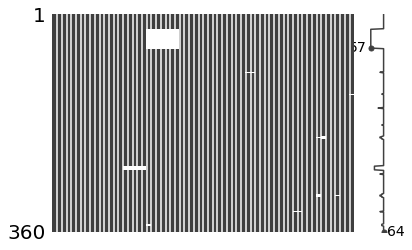

In [14]:
inspect_data(df = pollution_data, visualize_missing_value=True)

>>> Missing value visualization:


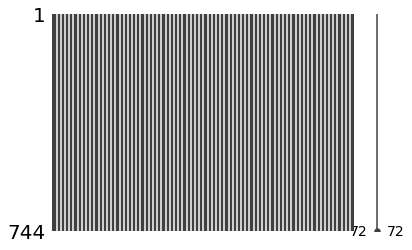

In [15]:
data = data.fillna(method='ffill')
data = data.fillna(method='bfill')
inspect_data(df = data, visualize_missing_value=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2020-01-01 00:00:00 to 2020-01-31 23:00:00
Freq: H
Data columns (total 72 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   no_station_3                 744 non-null    float64
 1   no2_station_3                744 non-null    float64
 2   pm2_5_station_3              744 non-null    float64
 3   o3_station_3                 744 non-null    float64
 4   so2_station_3                744 non-null    float64
 5   Benzene_station_3            744 non-null    float64
 6   Toluene_station_3            744 non-null    float64
 7   Ethylbenzene_station_3       744 non-null    float64
 8   M P-Xylene_station_3         744 non-null    float64
 9   O-Xylene_station_3           744 non-null    float64
 10  no_station_6                 744 non-null    float64
 11  no2_station_6                744 non-null    float64
 12  pm2_5_station_6              744 

# Feature Selection

The main goal of this notebook is to explore the various feature selection techniques and compare them in order to retain the best ones. But first, let's define clearly what is the feature selection.


### What is feature selection?

Feature selection is a dimensionnality reduction techniques aiming to choose a small subset of the relevant features from the original features by removing irrelevant, redundant, or noisy features. Feature selection usually can lead to better learning performance, higher learning accuracy, lower computational cost, and better model interpretability.

Feature selection occurs as a data preprocessing step in the ML pipeline. It has been proven to be effective and efficient in preparing high-dimensional data for machine learning and pattern recognition problems.

![Image of Danny Butvinik](https://miro.medium.com/max/888/1*vJdhKDHgLLV7el7Vm4PuEQ.jpeg)


### Which techniques?

Feature selection techniques can be roughly summarized in 3 categories: Filter, wrapper and embedded methods.

*   ***Filter methods***: features are selected based on statistical measures. It is independent of the learning algorithm and requires less computational time. Among existing techniques: chi-2, pearson correlation, missing value ratio..
*   ***Wrapper methods***: in wrapper methods a predictive model is used to evaluate a combination of features and assign model performance scores. The performance of the Wrapper method depends on the classifier. The best subset of features is selected based on the results of the classifier. Wrapper methods are computationally more expensive than filter methods, due to the repeated learning steps and cross-validation. However, these methods are more accurate than the filter method. Some of the examples are Recursive feature elimination, Sequential feature selection algorithms, and Genetic algorithms.
*   ***Embedded methods***: in embedded methods, there are ensemble learning and hybrid learning methods for feature selection. Since it has a collective decision, its performance is better than the other two models. Random forest is one such example. It is computationally less intensive than wrapper methods. However, this method has a drawback specific to a learning model.
In embedded techniques, the feature selection algorithm is integrated as part of the learning algorithm. The most typical embedded technique is the decision tree algorithm. Decision tree algorithms select a feature in each recursive step of the tree growth process and divide the sample set into smaller subset

![Image of Danny Butvinik](https://miro.medium.com/max/1400/1*9h2qPmOJonbCdthfeVkuyg.jpeg)



#### Pour tester les outputs de certaines techniques de feature selection, nous allons définir deux targets différentes représentant les polluants mesurés par les capteurs. Par défaut, nous allons prendre le PM 2.5 et le NO de la station 3.

In [17]:
#On définit notre target, ici par défaut NO de la station 3
target_1 = 'pm2_5_station_3'
target_2 = 'no_station_3'

#On définit le nombre de features à selectionner
n_features = 15

In [18]:
X = data.drop(target_1, axis=1)
y = data[target_1]

In [19]:
#X = X.iloc[:,:9]

## **Pearson Correlation (méthode filtrante)**

Statistique qui mesure la corrélation linéaire entre deux variables, qui sont toutes deux continues. Elle varie de -1 à +1, où
+1 correspond à une corrélation linéaire positive, 0 à une absence de corrélation linéaire, et -1 à une corrélation linéaire négative.


In [20]:
#Calcul du coefficient de pearson
target_correlation = data.corr()[[target_1]]

In [21]:
target_correlation

,pm2_5_station_3
no_station_3,0.282765
no2_station_3,0.570615
pm2_5_station_3,1.000000
o3_station_3,-0.570268
so2_station_3,0.066418
...,...
Dir. du vent (10s deg),0.011081
Vit. du vent (km/h),-0.289234
Visibilité (km),0.076909
Pression à la station (kPa),0.145295


In [22]:
features = list(abs(target_correlation).sort_values(by=target_1, ascending=False)[:10].index)

Grâce à cette méthode nous pouvons décider de ne garder que les features les plus corrélées avec notre target.

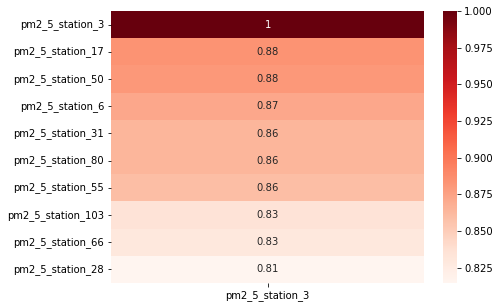

In [23]:
#On visualise sur une heatmap les corrélations avec la target
plt.figure(figsize=(7,5))

#On ne visualise sur les feature les plus corrélées avec la target
sns.heatmap(target_correlation.loc[features], annot=True, cmap=plt.cm.Reds)
plt.show()

Parmi les features les plus corrélées avec notre target, il faudrait garder uniquement celles qui ne sont pas énormément corrélées entre elles (sinon nous sommes sur une redondance d'information). Cette étape devrait être réalisée en amont avant toute autre technique de feature selection.

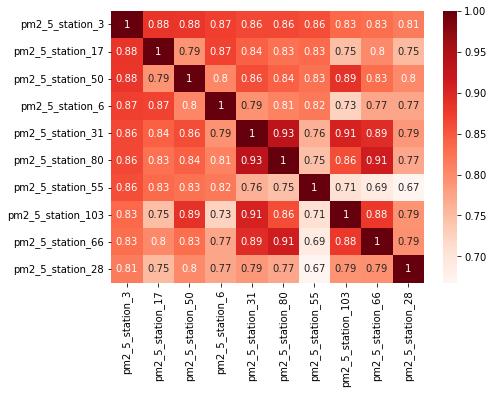

In [24]:
#We look at correlation between chosen features
feature_correlation = data.corr().loc[features][features]

plt.figure(figsize=(7,5))
sns.heatmap(feature_correlation, annot=True, cmap=plt.cm.Reds)
plt.show()

## **Recursive Feature Elimination (méthode wrapper)**

RFE recherche un sous-ensemble de features en commençant par toutes les features de l'ensemble de données d'apprentissage et en supprimant des features jusqu'à ce qu'il reste le nombre souhaité.

Pour ce faire, RFE utilise un modèle ML qui est ajusté. Les features sont classées par ordre d'importance. Les features les moins importantes sont éliminées et le modèle est réajusté. Ce processus est répété jusqu'à ce qu'il reste un nombre donné de caractéristiques.

In [25]:
#Comme l'algorithme de RFE est chronophage, on retire les feature les plus corrélées entre elles afin de réduire le temps de chargement
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

X = X.drop(correlated_features, axis=1)

Ici on utilise le modèle des Random Forests, un algorithme de classification composé de nombreux arbres de décision, comme modèle à la base de notre technique de feature selection.

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

rfc = RandomForestRegressor(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, verbose=True)
rfecv.fit(X, y)

Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 fea

/Users/ismaiilkad/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


RFECV(estimator=RandomForestRegressor(random_state=101), verbose=True)

RFE nous indiquer quel est le nombre de features optimal dans le modèle utilisé pour atteindre le meilleur score de regression/classification (regression dans notre cas)

In [29]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 9


In [31]:
optimal_features_ranking = rfecv.ranking_
ind = np.where(optimal_features_ranking == 1)[0]
print("Optimal features: ", list(X.iloc[:,ind].columns))

Optimal features:  ['Toluene_station_3', 'pm2_5_station_6', 'pm2_5_station_28', 'pst_station_28', 'pm10_station_50', 'co_station_66', 'no_station_80', 'no_station_103', 'pst_station_103']


/Users/ismaiilkad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


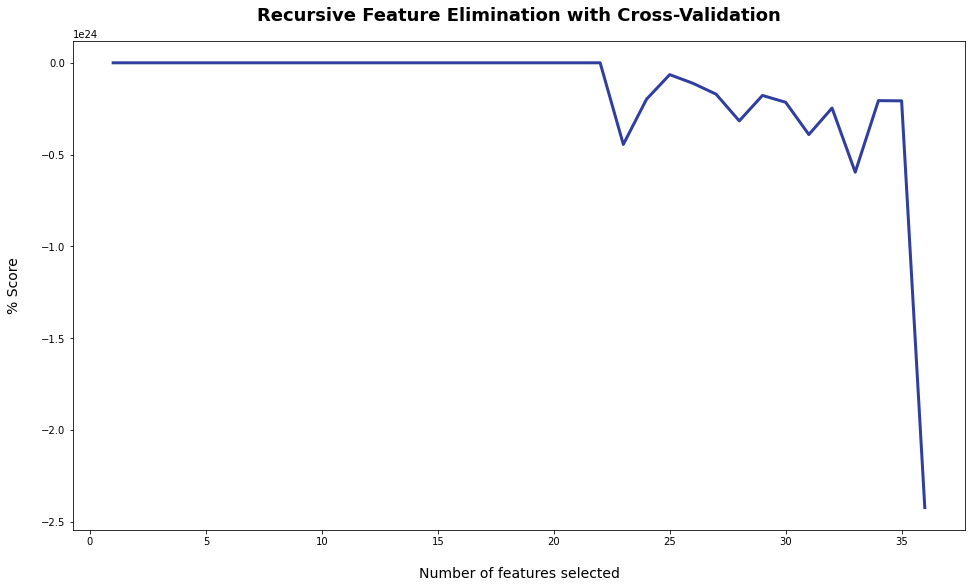

In [32]:
#Affichage du score en fonction du nombre de features prises en compte par le modèle
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Score', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.cv_results_['mean_test_score'], color='#303F9F', linewidth=3)

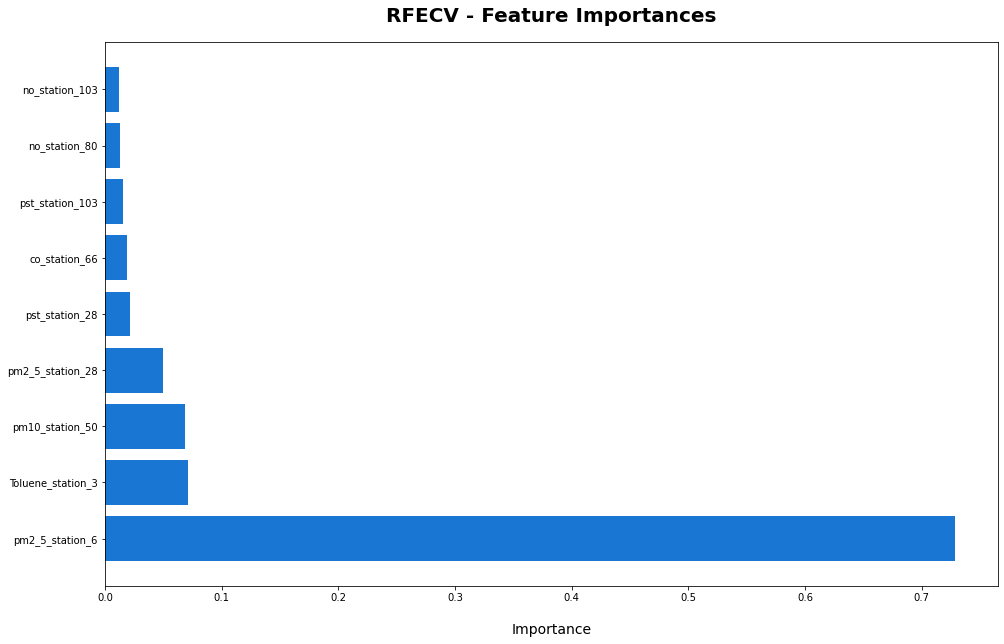

In [34]:
#Affichage de l'importance de toutes les features pour prédire la target
dset = pd.DataFrame()
dset['attr'] = X.iloc[:,ind].columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 10))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

## **Boruta (méthode wrapper)**

Contrairement à la technique RFE où les features étaient en compétition les unes avec les autres pour une place dans le sous-ensemble final, dans Boruta les features sont en compétition avec une version randomisée d'elles-mêmes (shadow features). Une feature n'est sélectionnée que si elle est plus performante que la feature aléatoire la plus performante.

![Image of Manish Pathak](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1520429681/boruta_algo_ft1i8z.png)

La procédure est répétée N fois (nombre d'essais) et l'étape finale consiste à comparer le nombre de fois où une feature a été meilleure que ses shadow features en utilisant une distribution binomiale. En ce qui concerne les features de la zone bleue, l'algorithme de Boruta est indécis,
tandis que les features dans la zone verte et rouge doivent être sélectionnées et éliminées, respectivement.

![Image of Samuele Mazzanti](https://miro.medium.com/max/1400/1*yqAUlMtPUiFyr8gYLFagTA.png)



In [35]:
from boruta import BorutaPy

#Le modèle ici est le même que pour le RFE, i.e un modèle Random Forest
estimator = RandomForestRegressor()

boruta = BorutaPy(estimator = estimator, n_estimators = 'auto', max_iter = 100, verbose=True)
boruta.fit(np.array(X), np.array(y))

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

BorutaPy(estimator=RandomForestRegressor(n_estimators=76,
                                         random_state=RandomState(MT19937) at 0x7F91CDEDF940),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F91CDEDF940, verbose=True)

On peut afficher les features considérées comme importantes, non-importantes et celles non catégorisées.

In [36]:
#Features importantes
important = list(X.columns[boruta.support_])
print(f"Features confirmed as important: {important}")

# Features non catégorisées
tentative = list(X.columns[boruta.support_weak_])
print(f"Unconfirmed features (tentative): {tentative}")

# Features non importantes
unimportant = list(X.columns[~(boruta.support_ | boruta.support_weak_)])
print(f"Features confirmed as unimportant: {unimportant}")

Features confirmed as important: ['no2_station_3', 'Benzene_station_3', 'Toluene_station_3', 'Ethylbenzene_station_3', 'pm2_5_station_6', 'co_station_17', 'co_station_28', 'no_station_28', 'pm2_5_station_28', 'pst_station_28', 'so2_station_31', 'pst_station_50', 'pm10_station_50', 'co_station_66', 'no_station_66', 'no_station_80', 'no_station_103', 'no2_station_103', 'pst_station_103', 'pm10_station_103', 'o3_station_103', 'Pression à la station (kPa)']
Unconfirmed features (tentative): ['no_station_31', 'no_station_99', 'Vit. du vent (km/h)']
Features confirmed as unimportant: ['no_station_3', 'so2_station_3', 'no_station_6', 'so2_station_6', 'no_station_17', 'so2_station_80', 'so2_station_99', 'Temp (°C)', 'Hum. rel (%)', 'Dir. du vent (10s deg)', 'Visibilité (km)']


In [37]:
optimal_features_ranking = boruta.ranking_
ind = np.where(optimal_features_ranking == 1)[0]
print("Optimal features: ", list(X.iloc[:,ind].columns))

Optimal features:  ['no2_station_3', 'Benzene_station_3', 'Toluene_station_3', 'Ethylbenzene_station_3', 'pm2_5_station_6', 'co_station_17', 'co_station_28', 'no_station_28', 'pm2_5_station_28', 'pst_station_28', 'so2_station_31', 'pst_station_50', 'pm10_station_50', 'co_station_66', 'no_station_66', 'no_station_80', 'no_station_103', 'no2_station_103', 'pst_station_103', 'pm10_station_103', 'o3_station_103', 'Pression à la station (kPa)']


## **Boruta SHAP (SHapley Additive exPlanation)**

In [39]:
#!pip install BorutaShap

from BorutaShap import BorutaShap

# Creates a BorutaShap selector for regression 
boruta_shap = BorutaShap(importance_measure = 'shap', classification = False)

In [40]:
# Fits the selector
boruta_shap.fit(X, y, n_trials = 50, verbose = True)
# n_trials -> number of iterations for Boruta algorithm
# sample -> samples the data so it goes faster

100%|██████████| 50/50 [03:42<00:00,  4.44s/it]

20 attributes confirmed important: ['no_station_99', 'no2_station_3', 'co_station_66', 'pm10_station_103', 'Benzene_station_3', 'o3_station_103', 'pst_station_28', 'Toluene_station_3', 'no_station_80', 'pm2_5_station_6', 'no_station_103', 'Pression à la station (kPa)', 'no2_station_103', 'so2_station_6', 'pm2_5_station_28', 'Ethylbenzene_station_3', 'co_station_17', 'no_station_66', 'so2_station_31', 'pm10_station_50']
11 attributes confirmed unimportant: ['so2_station_80', 'Dir. du vent (10s deg)', 'co_station_28', 'Visibilité (km)', 'no_station_17', 'Temp (°C)', 'no_station_3', 'Hum. rel (%)', 'no_station_6', 'so2_station_3', 'pst_station_50']
5 tentative attributes remains: ['Vit. du vent (km/h)', 'no_station_31', 'so2_station_99', 'no_station_28', 'pst_station_103']


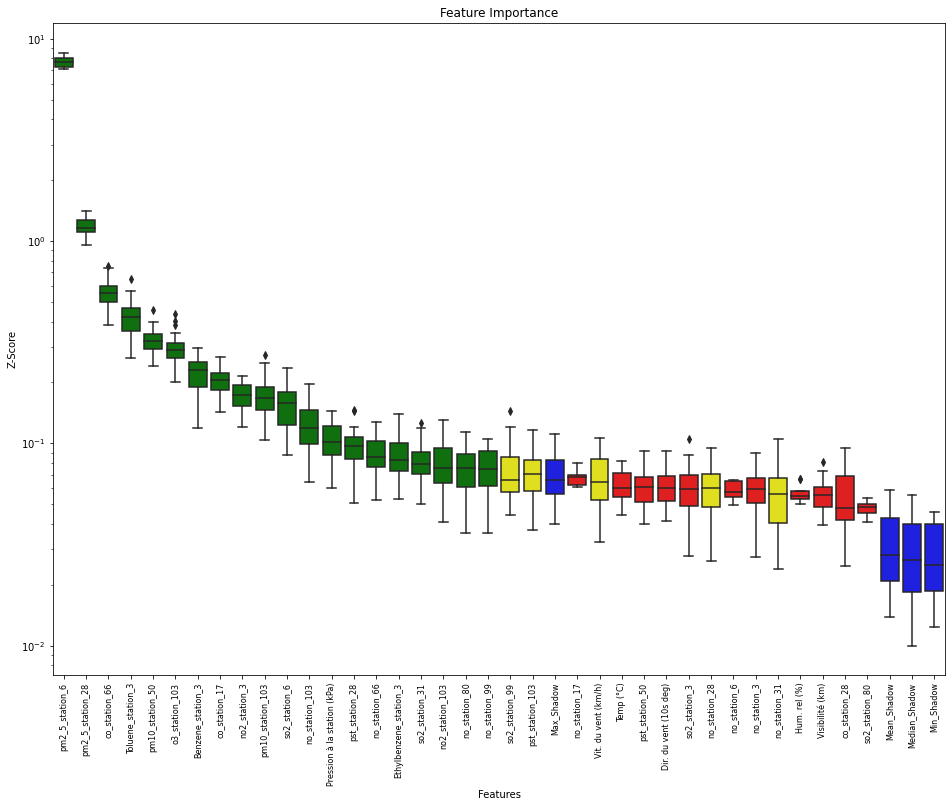

In [47]:
boruta_shap.plot(which_features='all', figsize=(16,12))